In [104]:
# Resolve paths from root project directory

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from data_tools import load_parsed_data

In [101]:
# Plot styles
import matplotlib.style as style
style.use('seaborn-poster')
style.use('ggplot')

In [18]:

from data_tools import load_crawled_terms
crawled_terms, crawled_hashtags, crawled_phrases = load_crawled_terms("../keywords-3nov.txt", split_hashtags=True)


['destroyed ballots',
 'discarded ballots',
 'election fraud',
 'election interference',
 'election tampering',
 'hacked voting machine',
 'pre-filled ballot',
 'stolen ballots',
 'ballot fraud',
 'ballot harvesting',
 'cheating democrats',
 'democrats cheat',
 'harvest ballot',
 'vote by mail fraud',
 'voter fraud']

In [122]:
def filter_df_by_timestamp(df):
    return df[(df.timestamp > '2020-11-06 00:00:00') & (df.timestamp < '2020-11-07 00:00:00')]

# Load our tweets
cast_cols = {
    "tweet_count": "int32",
    "quote_count": "int32" 
}

for term in crawled_terms:
    cast_cols[term] = "Sparse[int8]"

tweet_df = filter_df_by_timestamp(load_parsed_data('../data/14-nov/parsed_tweets.json', exclude_cols={
    "cleaned_text", 
    "entities",
    "replyTo",
    "replyTo_user",
    "text", 
    "last_retweeted", 
    "place", 
    "processed",
    "media", 
    "isDeleted"
}, cast_cols=cast_cols, verbose=True, index_col="datastore_id"))
retweet_df = filter_df_by_timestamp(load_parsed_data('../data/14-nov/parsed_retweets.json'))

Loading 2696807 json lines
(4%): 100000 lines in ../data/14-nov/parsed_tweets.json processed (2.0776078701019287 sec)
(7%): 200000 lines in ../data/14-nov/parsed_tweets.json processed (14.496349096298218 sec)
(11%): 300000 lines in ../data/14-nov/parsed_tweets.json processed (1.8893969058990479 sec)
(15%): 400000 lines in ../data/14-nov/parsed_tweets.json processed (1.8090739250183105 sec)
(19%): 500000 lines in ../data/14-nov/parsed_tweets.json processed (1.848909616470337 sec)
(22%): 600000 lines in ../data/14-nov/parsed_tweets.json processed (1.7290430068969727 sec)
(26%): 700000 lines in ../data/14-nov/parsed_tweets.json processed (2.654078960418701 sec)
(30%): 800000 lines in ../data/14-nov/parsed_tweets.json processed (2.590318202972412 sec)
(33%): 900000 lines in ../data/14-nov/parsed_tweets.json processed (10.67707896232605 sec)
(37%): 1000000 lines in ../data/14-nov/parsed_tweets.json processed (1.7334558963775635 sec)
(41%): 1100000 lines in ../data/14-nov/parsed_tweets.json 

In [125]:
# build lookup table for retweets
from collections import defaultdict 
retweets_by_user = defaultdict(lambda: set())

for retweet in retweet_df.itertuples():
    retweets_by_user[retweet.user].add(retweet.retweeted)

In [54]:
def is_tweet_tagged_with_hashtag(tweet, hashtag):
    for tweet_hashtag in tweet['entities']['hashtags']:
        if tweet_hashtag['text'].lower() == hashtag.lower():
            return True
    return False

def does_tweet_contain_any_term(tweet, terms):
    for term in terms:
        if term in tweet['full_text'].lower():
            return True
    return False

In [123]:
import gzip
import json
import os


hydrated_tweet_dir = './coverage-test/2020-11-06/'

line_count = 0
tweet_count = 0
retweet_count = 0
matching_tweets = []
matching_retweets = []

for filename in os.listdir(hydrated_tweet_dir):
    if filename.endswith(".jsonl.gz") and "06-18" not in filename:
        print("Processing {}".format(filename))
        with gzip.open(hydrated_tweet_dir + filename) as zipfile:
            for line in zipfile:
                tweet = json.loads(line)
                is_retweet = 'retweeted_status' in tweet
                match_array = matching_retweets if is_retweet else matching_tweets 
                
                line_count += 1
                if is_retweet:
                    retweet_count += 1
                else:
                    tweet_count += 1
                
                if (line_count % 25000 == 0):
                    print("Processed {} lines ({} tweets / {} retweets)".format(line_count, tweet_count, retweet_count))
                
                for hashtag in crawled_hashtags:
                    if (is_tweet_tagged_with_hashtag(tweet, hashtag)):
                        match_array.append(tweet)
                        break
                if (does_tweet_contain_any_term(tweet, crawled_phrases)):
                    match_array.append(tweet)
        print("Total crawled terms found: {} tweets / {} retweets".format(len(matching_tweets), len(matching_retweets)))

Processing us-presidential-tweet-id-2020-11-06-19.jsonl.gz
Processed 25000 lines (7060 tweets / 17940 retweets)
Processed 50000 lines (13656 tweets / 36344 retweets)
Processed 75000 lines (20486 tweets / 54514 retweets)
Processed 100000 lines (27259 tweets / 72741 retweets)
Processed 125000 lines (34123 tweets / 90877 retweets)
Processed 150000 lines (40848 tweets / 109152 retweets)
Processed 175000 lines (47711 tweets / 127289 retweets)
Processed 200000 lines (54436 tweets / 145564 retweets)
Total crawled terms found: 1444 tweets / 5714 retweets
Processing us-presidential-tweet-id-2020-11-06-13.jsonl.gz
Processed 225000 lines (61397 tweets / 163603 retweets)
Processed 250000 lines (68523 tweets / 181477 retweets)
Processed 275000 lines (75701 tweets / 199299 retweets)
Processed 300000 lines (82879 tweets / 217121 retweets)
Processed 325000 lines (90212 tweets / 234788 retweets)
Processed 350000 lines (97642 tweets / 252358 retweets)
Processed 375000 lines (105074 tweets / 269926 retwe

In [188]:
matching_tweets_by_term = defaultdict(lambda: set())
missing_tweets_by_term = defaultdict(lambda: set())
missing_tweets = []
missing_retweets = []

def add_tweet_to_term_stats(term_stats, tweet):
    for term in crawled_phrases:
        if term in tweet['full_text'].lower():
            term_stats[term].add(tweet['full_text'])
    for hashtag in crawled_hashtags:
        if (is_tweet_tagged_with_hashtag(tweet, hashtag)):
            term_stats['#' + hashtag].add(tweet['full_text'])

for tweet in matching_tweets:
    if (str(tweet['id']) in tweet_df.index):
        add_tweet_to_term_stats(matching_tweets_by_term, tweet)
    else:
        missing_tweets.append(tweet)
        add_tweet_to_term_stats(missing_tweets_by_term, tweet)

for retweet in matching_retweets:
    retweeted_tweet = retweet['retweeted_status']
    user_id = str(retweet['user']['id'])
    if (str(retweeted_tweet['id']) in retweets_by_user[user_id]):
        add_tweet_to_term_stats(matching_tweets_by_term, retweet)
    else:
        add_tweet_to_term_stats(missing_tweets_by_term, retweet)
        missing_retweets.append(retweet)

In [189]:
def print_missing_stats(matching, missing, stats_type):
    print("Missing {}/{} {} ({:,.1f}%)".format(
        len(missing),
        len(matching),
        stats_type,
        (len(missing) / len(matching)) * 100
    ))
    
    for (term, missing_tweet_set) in sorted(missing_tweets_by_term.items(), key=lambda x: -len(x[1])):
        if (len(missing_tweet_set) > 0):
            total = (len(missing_tweet_set) + len(matching_tweets_by_term[term]))
            print("Missed {:,.1f}% for term: '{}' ({}/{})".format(
                (len(missing_tweet_set) / total) * 100,
                term,
                len(missing_tweet_set),
                total
            ))      

In [193]:
print_missing_stats(matching_tweets, missing_tweets, 'tweets')

Missing 17620/24585 tweets (71.7%)
Missed 70.7% for term: 'voter fraud' (14610/20676)
Missed 70.7% for term: '#stopthesteal' (2712/3836)
Missed 69.6% for term: '#voterfraud' (2648/3803)
Missed 70.1% for term: 'election fraud' (2390/3410)
Missed 74.1% for term: '#electionfraud' (651/879)
Missed 70.6% for term: 'ballot harvesting' (551/780)
Missed 69.1% for term: 'ballot fraud' (487/705)
Missed 68.3% for term: 'election interference' (285/417)
Missed 83.8% for term: 'democrats cheat' (176/210)
Missed 80.1% for term: '#electioninterference' (137/171)
Missed 70.0% for term: '#ballotharvesting' (105/150)
Missed 62.1% for term: '#cheatingdemocrats' (90/145)
Missed 68.2% for term: '#voterfraudisreal' (73/107)
Missed 69.4% for term: 'stolen ballots' (50/72)
Missed 69.1% for term: 'cheating democrats' (47/68)
Missed 60.0% for term: 'election tampering' (45/75)
Missed 76.1% for term: '#ballotfraud' (35/46)
Missed 73.1% for term: '#democratvoterfraud' (19/26)
Missed 80.0% for term: '#stopvoterfra

In [194]:
print_missing_stats(matching_retweets, missing_retweets, 'retweets')

Missing 72041/94575 retweets (76.2%)
Missed 70.7% for term: 'voter fraud' (14610/20676)
Missed 70.7% for term: '#stopthesteal' (2712/3836)
Missed 69.6% for term: '#voterfraud' (2648/3803)
Missed 70.1% for term: 'election fraud' (2390/3410)
Missed 74.1% for term: '#electionfraud' (651/879)
Missed 70.6% for term: 'ballot harvesting' (551/780)
Missed 69.1% for term: 'ballot fraud' (487/705)
Missed 68.3% for term: 'election interference' (285/417)
Missed 83.8% for term: 'democrats cheat' (176/210)
Missed 80.1% for term: '#electioninterference' (137/171)
Missed 70.0% for term: '#ballotharvesting' (105/150)
Missed 62.1% for term: '#cheatingdemocrats' (90/145)
Missed 68.2% for term: '#voterfraudisreal' (73/107)
Missed 69.4% for term: 'stolen ballots' (50/72)
Missed 69.1% for term: 'cheating democrats' (47/68)
Missed 60.0% for term: 'election tampering' (45/75)
Missed 76.1% for term: '#ballotfraud' (35/46)
Missed 73.1% for term: '#democratvoterfraud' (19/26)
Missed 80.0% for term: '#stopvoterf

### Random sample of missing tweets/retweets



In [195]:
import numpy as np

print("-- Missing tweets --")
for tweet in np.random.choice(missing_tweets, 5):
    print("[{}]: {}".format(tweet['id'], tweet['full_text']))
    print()

print()

print("-- Missing retweets --")
for retweet in np.random.choice(missing_retweets, 5):
    print("[{}]: {}".format(retweet['id'], retweet['full_text']))
    print()

-- Missing tweets --
[1324701364509904899]: Donald Trump has won. A stolen election will never be accepted. #FightBack #StopTheSteal https://t.co/lG8dtvsLz2

[1324599052780986368]: @TheRISEofROD @CobaltGuy1 I know voter fraud is serious but I can’t stop laughing at you saying, “what the actual fuck is going on” 😂

[1324535613752827904]: Great work @Project_Veritas for working hard on this. Can't believe how bad this has got.. #voterfraud https://t.co/DWTfpNTxh6

[1324562910115471360]: Of course...we need to follow this thru to the end! There are plenty of evidences &amp; whistleblowers!! THIS IS ABOUT INTEGRITY OF OUR ELECTIONS &amp; OUR VOTING RIGHTS NOT ABOUT THE LEFT!! What everybody is forgetting is election tampering is a Federal crime! https://t.co/hSoMCOMnTT

[1324622122048651264]: Indian journos on US elections: OMG, Trump is alleging voter fraud without any evidence. Very dangerous. 

Indian journos on Indian elections: Reports on social media that no matter which buttons you 

In [150]:
def filter_by_term(df, term):
    m = df.apply(lambda x: term in x['full_text'].lower(), axis=1)
    return df[m]

# Create a dataframe from matched tweets/retweets
matching_tweet_df = pd.DataFrame(matching_tweets, columns=['full_text', 'created_at']).rename(columns={
    "created_at": "timestamp"
})

matching_retweet_df = pd.DataFrame(matching_tweets, columns=['full_text','created_at']).rename(columns={
    "created_at": "timestamp"
})


In [200]:
def group_df_by_hour(df, column='timestamp'):
    grouped_by_hour = (pd.to_datetime(df[column])
        .dt.floor('H')
        .value_counts()
        .rename_axis('date')
        .reset_index(name='count')).sort_values(by=['date'])
    return grouped_by_hour.set_index('date')

def plot_hourly_coverage(our_df, matching_df, title):
    our_df_by_hour = group_df_by_hour(our_df)
    matching_df_by_hour = group_df_by_hour(matching_df)

    fig, ax = plt.subplots()

    ax.plot(
        our_df_by_hour["count"], label="Our dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.plot(
        matching_df_by_hour["count"], label="Their dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = 2))

    ax.set_title("Coverage for '{}' (total={:,}/{:,})".format(title, len(our_df.index), len(matching_df.index)))

    return fig

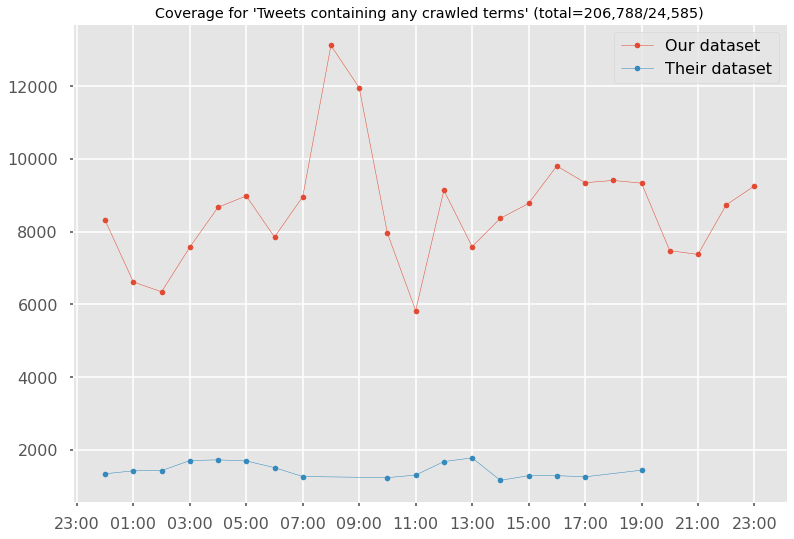

In [201]:
plot_hourly_coverage(tweet_df, matching_tweets_df, "Tweets containing any crawled terms")
None

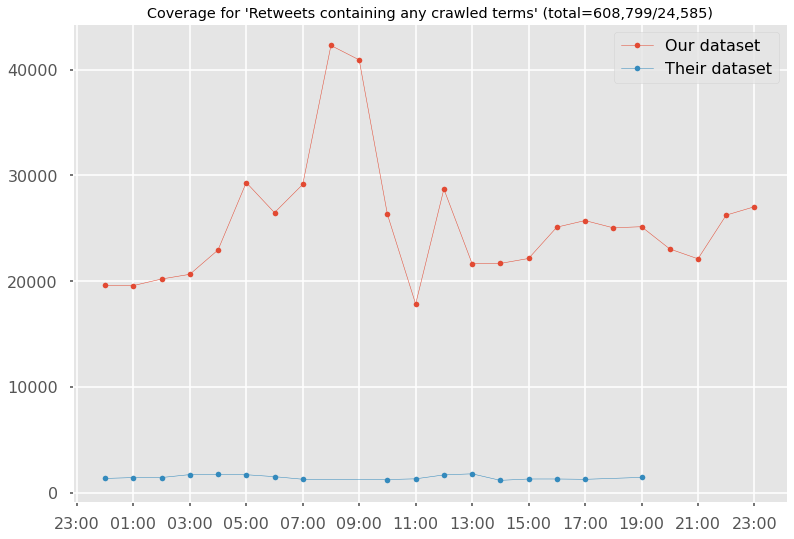

In [202]:
plot_hourly_coverage(retweet_df, matching_retweet_df, "Retweets containing any crawled terms")
None

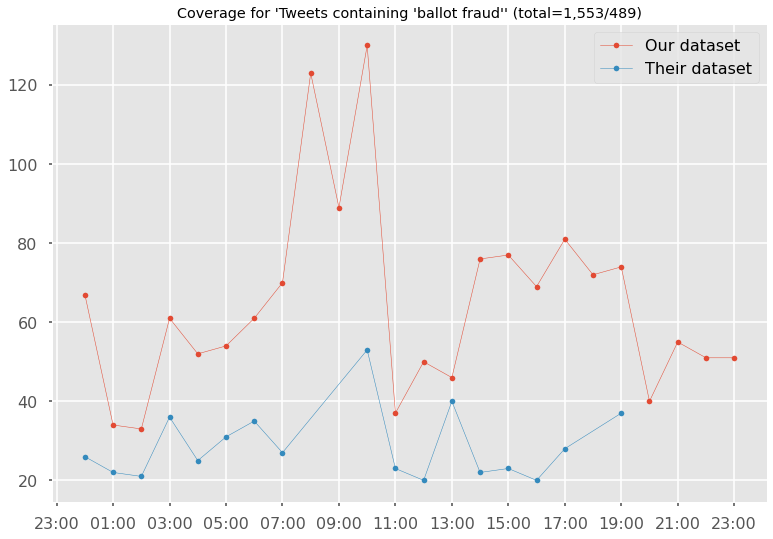

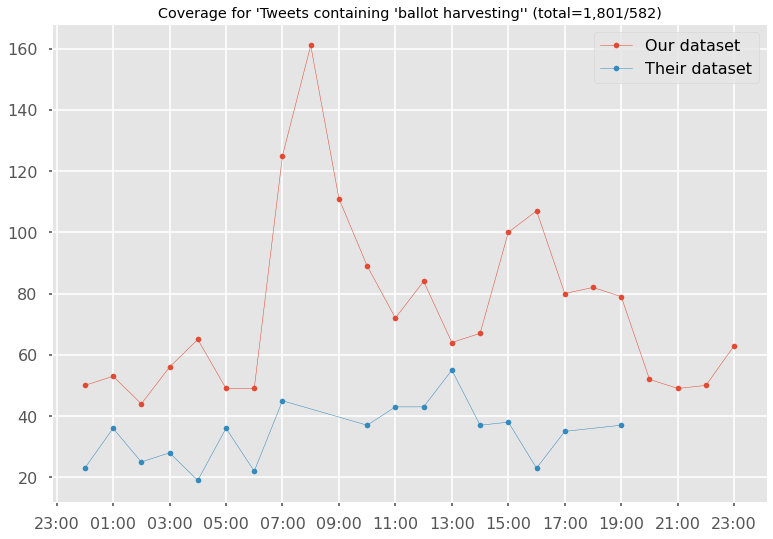

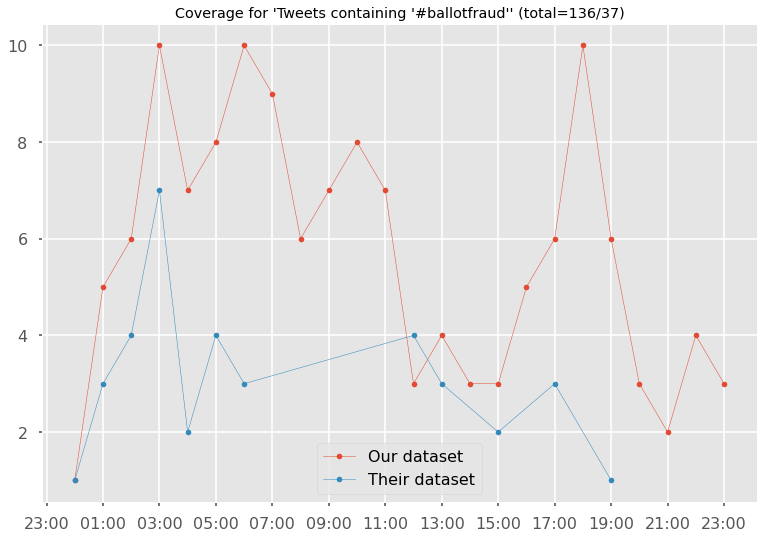

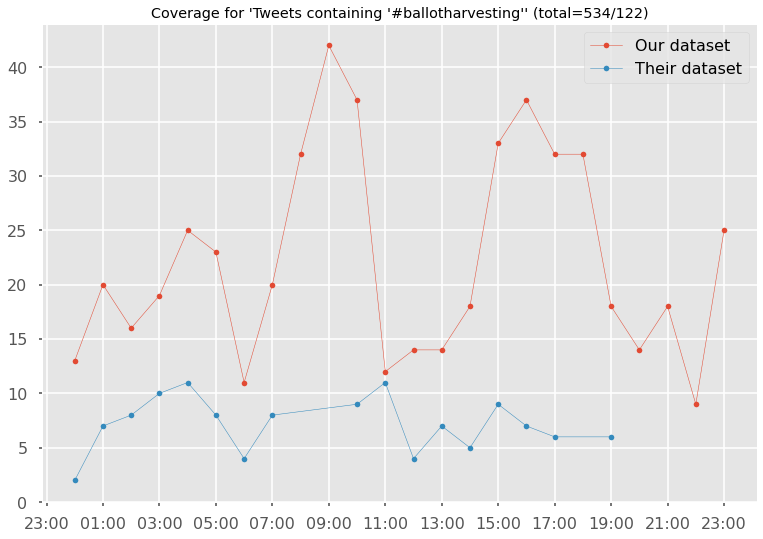

In [204]:
overlapping_terms = ["ballot fraud", "ballot harvesting", "#ballotfraud", "#ballotharvesting"]

for term in overlapping_terms:
    plot_hourly_coverage(tweet_df[tweet_df[term] == 1], filter_by_term(matching_tweet_df, term), "Tweets containing '{}'".format(term))
